# 3. Convolutional LSTM

## 데이터 수집

In [2]:
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import date, datetime

today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = datetime(2013,1,1)

# BTC(KRW)
yfin.pdr_override()

btc_krwname = 'Bitcoin(KRW)'
btc_krw = 'BTC-KRW'
btc_krw_df = pdr.get_data_yahoo(btc_krw, start=date_start, end=date_today)

print(btc_krw_df.shape)
btc_krw_df

[*********************100%***********************]  1 of 1 completed
(3176, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,4.826118e+05,4.838110e+05,4.681210e+05,4.732035e+05,4.732035e+05,21787470960
2014-09-18,4.727130e+05,4.762765e+05,4.309914e+05,4.428182e+05,4.428182e+05,35976322560
2014-09-19,4.424667e+05,4.475154e+05,4.012784e+05,4.119893e+05,4.119893e+05,39571102935
2014-09-20,4.118610e+05,4.417305e+05,4.068624e+05,4.267118e+05,4.267118e+05,38469009780
2014-09-21,4.258571e+05,4.303872e+05,4.103040e+05,4.161897e+05,4.161897e+05,27737663355
...,...,...,...,...,...,...
2023-05-24,3.529357e+07,3.598590e+07,3.517012e+07,3.594313e+07,3.594313e+07,18082910616976
2023-05-25,3.594165e+07,3.594165e+07,3.446848e+07,3.473084e+07,3.473084e+07,21495559019063
2023-05-26,3.472378e+07,3.536380e+07,3.423304e+07,3.524552e+07,3.524552e+07,18438822300836


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 데이터 분할
train_size = int(len(btc_krw_df) * 0.8)
train_data = btc_krw_df[:train_size]
test_data = btc_krw_df[train_size:]

# 분위수 정규화 수행
normalized_train_data = rankdata(train_data['Adj Close']) / len(train_data)
normalized_test_data = rankdata(test_data['Adj Close']) / len(test_data)

# 추세 제거를 위한 이동평균 계산
window = 60  # 이동평균 윈도우 크기
rolling_mean_train = pd.Series(normalized_train_data).rolling(window=window, min_periods=1).mean()
rolling_mean_test = pd.Series(normalized_test_data).rolling(window=window, min_periods=1).mean()

# 추세 제거
detrended_train_data = normalized_train_data - rolling_mean_train
detrended_test_data = normalized_test_data - rolling_mean_test

# 정규화된 데이터로 원계열 복원
restored_train_data = detrended_train_data * len(train_data)
restored_test_data = detrended_test_data * len(test_data)

# 시계열 데이터 추출
trfd_btc_krw_series_train = restored_train_data.values
trfd_btc_krw_series_test = restored_test_data.values

# 시퀀스 데이터 생성
sequence_length = 7  # 입력 시퀀스 길이
X_train = []
y_train = []
for i in range(len(trfd_btc_krw_series_train) - sequence_length):
    X_train.append(trfd_btc_krw_series_train[i:i + sequence_length])
    y_train.append(trfd_btc_krw_series_train[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range(len(trfd_btc_krw_series_test) - sequence_length):
    X_test.append(trfd_btc_krw_series_test[i:i + sequence_length])
    y_test.append(trfd_btc_krw_series_test[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Convolutional LSTM 모델 구축
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(sequence_length, 1)))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))  # L2 규제 추가
model.add(Dropout(0.1))
model.add(LSTM(units=32, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))  # L2 규제 추가
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train[..., np.newaxis], y_train, epochs=1000, batch_size=32, verbose=1,
                    validation_data=(X_test[..., np.newaxis], y_test), callbacks=[early_stopping])

# 학습 데이터 예측
train_predictions = model.predict(X_train[..., np.newaxis])
train_predictions = train_predictions.flatten()

# 테스트 데이터 예측
test_predictions = model.predict(X_test[..., np.newaxis])
test_predictions = test_predictions.flatten()

Epoch 1/1000
80/80 [==============================] - 4s 14ms/step - loss: 19533.7637 - val_loss: 5855.0352
Epoch 2/1000
80/80 [==============================] - 0s 5ms/step - loss: 18608.9707 - val_loss: 5382.0181
Epoch 3/1000
80/80 [==============================] - 0s 5ms/step - loss: 17945.5840 - val_loss: 5012.3491
Epoch 4/1000
80/80 [==============================] - 1s 7ms/step - loss: 17390.8438 - val_loss: 4689.6055
Epoch 5/1000
80/80 [==============================] - 1s 6ms/step - loss: 16914.3262 - val_loss: 4435.1753
Epoch 6/1000
80/80 [==============================] - 0s 6ms/step - loss: 16471.1875 - val_loss: 4178.9961
Epoch 7/1000
80/80 [==============================] - 0s 5ms/step - loss: 16087.8154 - val_loss: 3975.7786
Epoch 8/1000
80/80 [==============================] - 0s 6ms/step - loss: 15710.0195 - val_loss: 3778.1296
Epoch 9/1000
80/80 [==============================] - 0s 6ms/step - loss: 15360.3945 - val_loss: 3606.3340
Epoch 10/1000
80/80 [===============

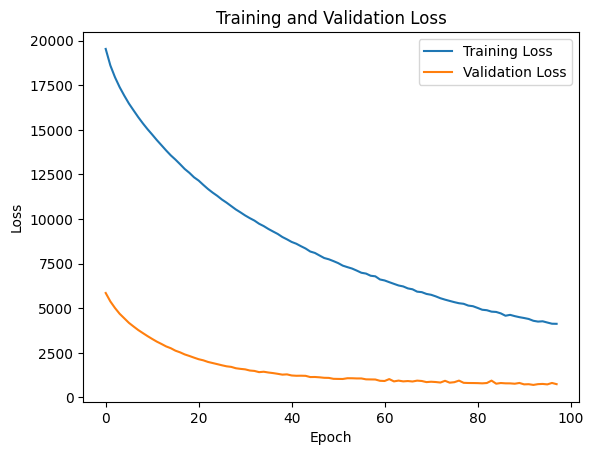

In [148]:
# Loss 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 데이터 분할
train_size = int(len(btc_krw_df) * 0.8)
train_data = btc_krw_df[:train_size]
test_data = btc_krw_df[train_size:]

# Min-Max 정규화 수행
scaler = MinMaxScaler()
normalized_train_data = scaler.fit_transform(train_data['Adj Close'].values.reshape(-1, 1)).flatten()
normalized_test_data = scaler.transform(test_data['Adj Close'].values.reshape(-1, 1)).flatten()

# 추세 제거를 위한 이동평균 계산
window = 60  # 이동평균 윈도우 크기
rolling_mean_train = pd.Series(normalized_train_data).rolling(window=window, min_periods=1).mean()
rolling_mean_test = pd.Series(normalized_test_data).rolling(window=window, min_periods=1).mean()

# 추세 제거
detrended_train_data = normalized_train_data - rolling_mean_train
detrended_test_data = normalized_test_data - rolling_mean_test

# 시계열 데이터 추출
trfd_btc_krw_series_train = detrended_train_data
trfd_btc_krw_series_test = detrended_test_data

# 시퀀스 데이터 생성
sequence_length = 7  # 입력 시퀀스 길이
X_train = []
y_train = []
for i in range(len(detrended_train_data) - sequence_length):
    X_train.append(detrended_train_data[i:i + sequence_length])
    y_train.append(detrended_train_data[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range(len(detrended_test_data) - sequence_length):
    X_test.append(detrended_test_data[i:i + sequence_length])
    y_test.append(detrended_test_data[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Convolutional LSTM 모델 구축
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(sequence_length, 1)))
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))  # 과적합 방지
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.1))  # 과적합 방지
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# 학습 데이터 예측
train_predictions = model.predict(X_train)
train_predictions = train_predictions.flatten()

# 테스트 데이터 예측
test_predictions = model.predict(X_test)
test_predictions = test_predictions.flatten()

Epoch 1/1000
80/80 [==============================] - 4s 15ms/step - loss: 7.9758e-04 - val_loss: 9.4858e-04
Epoch 2/1000
80/80 [==============================] - 0s 6ms/step - loss: 3.1882e-04 - val_loss: 6.8757e-04
Epoch 3/1000
80/80 [==============================] - 1s 8ms/step - loss: 2.7970e-04 - val_loss: 7.6582e-04
Epoch 4/1000
80/80 [==============================] - 0s 6ms/step - loss: 2.7404e-04 - val_loss: 5.3562e-04
Epoch 5/1000
80/80 [==============================] - 1s 7ms/step - loss: 2.0508e-04 - val_loss: 4.9108e-04
Epoch 6/1000
80/80 [==============================] - 1s 7ms/step - loss: 1.9173e-04 - val_loss: 5.1900e-04
Epoch 7/1000
80/80 [==============================] - 0s 6ms/step - loss: 1.6678e-04 - val_loss: 4.4638e-04
Epoch 8/1000
80/80 [==============================] - 1s 7ms/step - loss: 1.9310e-04 - val_loss: 6.7621e-04
Epoch 9/1000
80/80 [==============================] - 0s 6ms/step - loss: 2.3545e-04 - val_loss: 3.9042e-04
Epoch 10/1000
80/80 [======

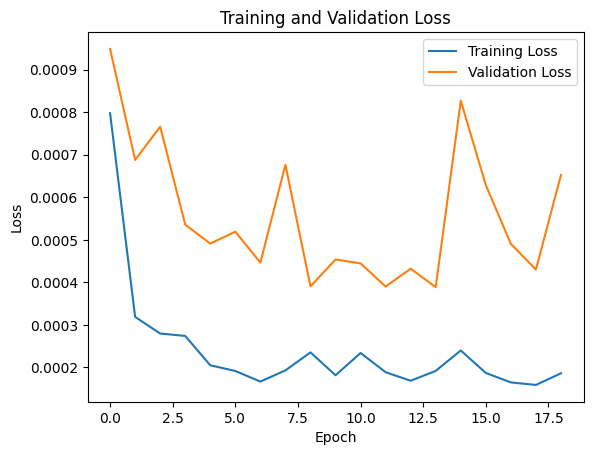

In [135]:
# Loss 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 지표 계산
test_mse = mean_squared_error(X_test, test_predictions)
test_mae = mean_absolute_error(X_test, test_predictions)
test_r2 = r2_score(X_test, test_predictions)

# 성능 지표 출력
print("Mean Squared Error (MSE):", test_mse)
print("Mean Absolute Error (MAE):", test_mae)
print("R-squared (R2):", test_r2)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(btc_krw_df.index, btc_krw_df['Adj Close'], label='Actual', alpha=0.5)
plt.plot(btc_krw_df.index[sequence_length:sequence_length+len(train_predictions)], train_predictions['Predicted'], label='Predicted (Train)')
plt.plot(btc_krw_df.index[sequence_length+len(train_predictions):], test_predictions['Predicted'], label='Predicted (Test)')
plt.xlabel('Date')
plt.ylabel('BTC-KRW Price')
plt.title('BTC-KRW Price Prediction')
plt.legend()
plt.show()

ValueError: y_true and y_pred have different number of output (7!=1)